* 提取信息
    * 目的 :
        1. 从大量的非结构化文本信息中抽取出结构化信息
        2. 描述文本中的实体关系
        3. 利用相关的语料库执行这些操作
    * 流程
        1. 转化非结构文本信息到结构化文本信息
        2. 利用SQL等将对应的结构化文本信息抽取出来
    * 信息提取结构
        1. 断句
        2. 分词
        3. 词性标注
        4. 命名实体识别
        5. 确认结构化数据(列表等) - 关系抽取

In [2]:
# 实现1, 2, 3
import nltk
def process(document):
    sents = nltk.sent_tokenize(document)
    sents = [nltk.word_tokenize(sent) for sent in sents]
    sents = [nltk.pos_tag(i) for i in sents]
    return sents
# process(nltk.corpus.ieer.raw('NYT_19980315'))

* 实体识别  
    * 用于实体识别的技术我们一般使用**分块(chunking)**
        * 分块实际上就是对一个句子的语法组成的分块，每一块代表一个句子逻辑中的而一个实体或者动作等
        * 分块不能出现重叠
    * 分块的分类
        * 名词短语分块(NP-Chunking)
            1. 寻找单独名词短语对应的块
            2. NP分块不能包含其他的NP分块(对名词的修饰介词短语或者从句不属于名词的NP分块内部，因为包含有更多的NP分块)
            3. 信息来源 :
                * 词性标注
                * 分块语法:
                    1. 规定如何分块
                    2. 标记模式（语法）
                        组成块语法的规则利用标记模式秒数已标注的词的序列，标记模式是用<>分割的词性标记序列
                        ```
                        <DT>?<JJ>*<NN>
                        ```
                    3. 用正则表达式分块  
                        可以使用多个更新的分块规则，但所有的分块规则都试验之后返回结果块结构
                    4. 缝隙  
                        所谓的加缝隙本质上是对已经存在的分块进行一个继续划分
                * 表示分块
                    * IOB表示法
                        1. I : 分块的内部非头元素
                        2. B : 分块的内部头元素
                        3. O : 分块外元素(叶子节点)
                    * 树表示 : NLTK内部使用该方式，但是提供和IOB表示法的转换接口

In [13]:
import nltk
sentence = 'the little yellow dog barked at the cat'
sents = nltk.pos_tag(nltk.word_tokenize(sentence))
print(sents)    # 词性标注
grammer = "NP: {<DT>?<JJ>*<NN>}"    # NP分块器的正则表达式分块语法
cp = nltk.RegexpParser(grammer)
result = cp.parse(sents)
print(result)    # 显示分块结果

[('the', 'DT'), ('little', 'JJ'), ('yellow', 'JJ'), ('dog', 'NN'), ('barked', 'VBD'), ('at', 'IN'), ('the', 'DT'), ('cat', 'NN')]
(S
  (NP the/DT little/JJ yellow/JJ dog/NN)
  barked/VBD
  at/IN
  (NP the/DT cat/NN))
(S
  (NP the/DT little/JJ yellow/JJ dog/NN)
  barked/VBD
  at/IN
  (NP the/DT cat/NN))
(NP the/DT little/JJ yellow/JJ dog/NN)
(NP the/DT cat/NN)


In [4]:
sentence = 'another sharp dive trade figures any new policy measures earlier stages Panamanian dictator Manuel Noriega'
sents = nltk.pos_tag(nltk.word_tokenize(sentence))
print(sents)
grammer = 'NP: {<DT>?<JJ.*>*<NN.*>+}'
cp = nltk.RegexpParser(grammer)
result = cp.parse(sents)
print(result)

[('another', 'DT'), ('sharp', 'JJ'), ('dive', 'JJ'), ('trade', 'NN'), ('figures', 'NNS'), ('any', 'DT'), ('new', 'JJ'), ('policy', 'NN'), ('measures', 'NNS'), ('earlier', 'RBR'), ('stages', 'NNS'), ('Panamanian', 'JJ'), ('dictator', 'NN'), ('Manuel', 'NNP'), ('Noriega', 'NNP')]
(S
  (NP another/DT sharp/JJ dive/JJ trade/NN figures/NNS)
  (NP any/DT new/JJ policy/NN measures/NNS)
  earlier/RBR
  (NP stages/NNS)
  (NP Panamanian/JJ dictator/NN Manuel/NNP Noriega/NNP))


In [19]:
# 使用正则表达式分快器
# 注意result的结果是一个解析树
grammer = r'''
    NP: {<DT|PRP\$>?<JJ>*<NN>}    # 注释1
        {<NNP>+}    # 注释2'''   
cp = nltk.RegexpParser(grammer)
sentence = 'Rapunzel let down her long golden hair'
sents = nltk.pos_tag(nltk.word_tokenize(sentence))
result = cp.parse(sents)
print(result)

print('-' * 20)
# 打开解析树
for i in result.subtrees():
    print(i.label(), i)

(S
  (NP Rapunzel/NNP)
  let/VBD
  down/RP
  (NP her/PRP$ long/JJ golden/JJ hair/NN))
--------------------
S (S
  (NP Rapunzel/NNP)
  let/VBD
  down/RP
  (NP her/PRP$ long/JJ golden/JJ hair/NN))
NP (NP Rapunzel/NNP)
NP (NP her/PRP$ long/JJ golden/JJ hair/NN)


In [3]:
# 加缝隙
grammer = r'''
    NP: {<DT>?<JJ>*<NN>+}
        }<JJ>+{    # 加缝隙，用动词对已有的分块划分
'''
sentence = 'the little yellow dog barked at the cat'
sents = nltk.pos_tag(nltk.word_tokenize(sentence))
cp = nltk.RegexpParser(grammer)
print(cp.parse(sents))

(S
  (NP the/DT)
  little/JJ
  yellow/JJ
  (NP dog/NN)
  barked/VBD
  at/IN
  (NP the/DT cat/NN))


* 开发和评估分快器
    1. IBO 转换成 NLTK树状图的形式，学习一个分快起在一个语料库上的评分标准
    2. 使用corpora模块访问大量已经分块的文本  
        我们现在可以访问已经分块的黄金标准语料库，用其来评估分类器
        * 训练模块
        * 测试模块
    3. 常用函数解析
        * ```nltk.chunked_sents('train.txt', chunk_types=['NP'])```  
            返回树型的IOB结构组成的列表
        * ```nltk.chunk.tree2conlltags(t)```  
            输入要转化的树结构，返回三元组(word, tag, IBO-tag)列表
            * word : 对应的词
            * tag : word的词性
            * IBO-tag : 对应的word的IBO标记
        * ```nltk.chunk.conllstr2tree(s, chunk_types=['NP', 'PP', 'VP'], root_label='S')```  
            转换字符串的IBO串到一个树结构
            * s : 是要转换的字符串
            * chunk_types : 是要决定的分块的标准
        * ```nltk.chunk.conlltags2tree(s, chunk_types=[...])```  
            转换一个三元组标记列表成为一个树
    4. 分块器
        * 词性标记分块器
            * 正则表达式分块器
            * Unigram / Bigram标注器改造的分块器
        * 但是如果单单的使用词性标注来考虑我们的分块有时候是不和常理的，我们还需要将词的内容信息最为词性标记分块器的补充
            * n-grams : 基于分类器的标注器对句子分块，比如n-grams分块器

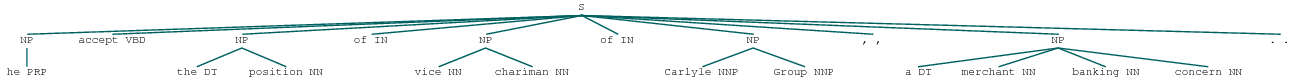

In [1]:
import nltk
text = '''
he PRP B-NP
accept VBD B-VP
the DT B-NP
position NN I-NP
of IN B-PP
vice NN B-NP
chariman NN I-NP
of IN B-PP
Carlyle NNP B-NP
Group NNP I-NP
, , O
a DT B-NP
merchant NN I-NP
banking NN I-NP
concern NN I-NP
. . O
'''
nltk.chunk.conllstr2tree(text, chunk_types=['NP'])

In [4]:
from nltk.corpus import conll2000
print(conll2000.chunked_sents('train.txt', chunk_types=['NP'])[99])

(S
  Over/IN
  (NP a/DT cup/NN)
  of/IN
  (NP coffee/NN)
  ,/,
  (NP Mr./NNP Stone/NNP)
  told/VBD
  (NP his/PRP$ story/NN)
  ./.)


In [17]:
# 使用词性标注的分块器
from nltk.corpus import conll2000
import nltk
cp = nltk.RegexpParser("")    # 空语法
testsents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
print(cp.evaluate(testsents))     # 显示我们的数据在测试集上的精确度，召回率，和F度量，但是显示有超过1/3的数据是O

# 虽然效果相对来说不错，但是可以采用更多的数据驱动方式来进行改变
cp = nltk.RegexpParser("NP: {<[CDJNP].*>+}")
testsents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
print(cp.evaluate(testsents))     # 显示我们的数据在测试集上的精确度，召回率，和F度量，但是显示有超过1/3的数据是O

# 集成Unigram算法的模型转变标注器成为一个分块器
class Unigramchunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        train_data = [[(t, c) for w, t, c in nltk.chunk.tree2conlltags(sent)] for sent in train_sents]
        self.tagger = nltk.UnigramTagger(train_data)
    def parse(self, sentence):
        pos_tags = [pos for (word, pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word, pos), chunktag) in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)

testsents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
trainsents = conll2000.chunked_sents('train.txt', chunk_types=['NP'])
unichunker = Unigramchunker(trainsents)
print(unichunker.evaluate(testsents))

ChunkParse score:
    IOB Accuracy:  43.4%%
    Precision:      0.0%%
    Recall:         0.0%%
    F-Measure:      0.0%%
ChunkParse score:
    IOB Accuracy:  87.7%%
    Precision:     70.6%%
    Recall:        67.8%%
    F-Measure:     69.2%%
ChunkParse score:
    IOB Accuracy:  92.9%%
    Precision:     79.9%%
    Recall:        86.8%%
    F-Measure:     83.2%%


In [18]:
# 词性标注 + 词意内容　分块器
# 使用连续分类器(6中提到，是使用之前的历史记录对之后的词性标注产生指导性作用，相当于引入了词的含义信息)

def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    return {'pos': pos}

class ConsecutiveTagger(nltk.TaggerI):
    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i ,history)

IndentationError: expected an indented block (<ipython-input-18-522671b38f78>, line 6)